In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error


# Partie 1 : Analyse exploratoire des données (EDA)


In [62]:
data = pd.read_csv('data.csv')
data = data.loc[:, ~data.columns.str.contains("^Unnamed")]
print(data.head())
print(data.columns)
data.shape[0]
data.describe()
print(str('Any missing data or NaN in the dataset:'),data.isnull().values.any())
data.info()
data.duplicated()
data.duplicated().sum()

                       Indicator  Region  Year  Value_millions  Value_per100
0  Fixed-telephone subscriptions  Africa  2005            10.3           1.5
1  Fixed-telephone subscriptions  Africa  2006            11.0           1.5
2  Fixed-telephone subscriptions  Africa  2007            11.3           1.5
3  Fixed-telephone subscriptions  Africa  2008            11.6           1.5
4  Fixed-telephone subscriptions  Africa  2009            12.6           1.6
Index(['Indicator', 'Region', 'Year', 'Value_millions', 'Value_per100'], dtype='object')
Any missing data or NaN in the dataset: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Indicator       1560 non-null   object 
 1   Region          1560 non-null   object 
 2   Year            1560 non-null   int64  
 3   Value_millions  1038 non-null   float64
 4   Value_per100    1028 no

np.int64(0)

In [63]:
# Standardiser les colonnes numériques
numeric_cols = data[['Value_millions', 'Value_per100']].columns
df_scaled = data.copy()
scaler = StandardScaler()
df_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])
data=df_scaled

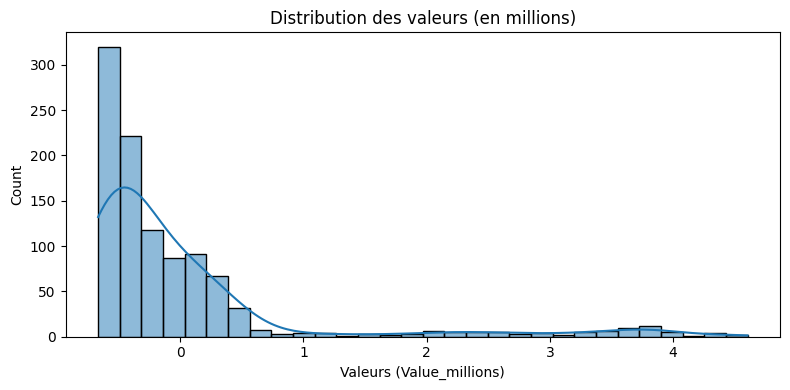

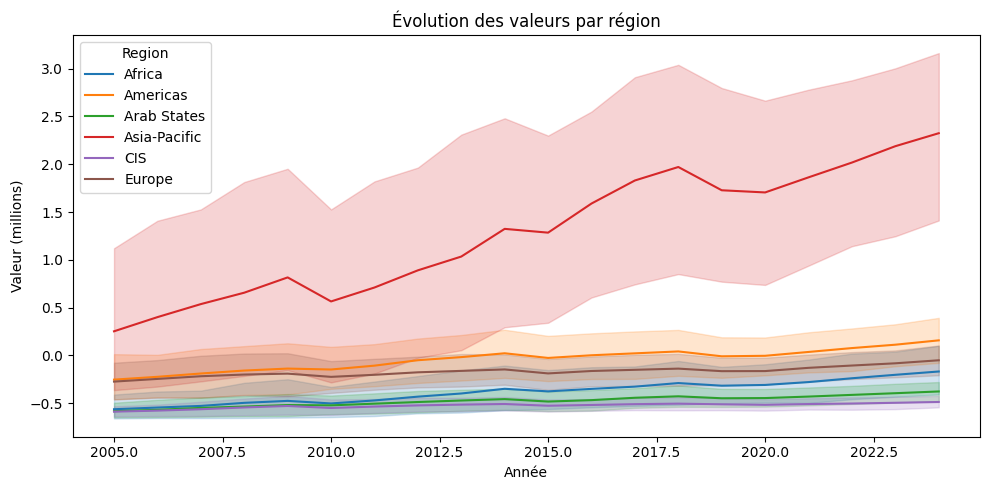

In [64]:

plt.figure(figsize=(8, 4))
sns.histplot(data["Value_millions"].dropna(), kde=True, bins=30)
plt.title("Distribution des valeurs (en millions)")
plt.xlabel("Valeurs (Value_millions)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x="Year", y="Value_millions", hue="Region", legend=True)
plt.title("Évolution des valeurs par région")
plt.xlabel("Année")
plt.ylabel("Valeur (millions)")
plt.tight_layout()
plt.show()




# Partie 2 : Préparation des données
Nous nettoyons les valeurs manquantes et normalisons les variables pour la modélisation.

In [65]:
#print(data.info())
print(data.describe())
print(data.isna().sum())

             Year  Value_millions  Value_per100
count  1560.00000     1038.000000  1.028000e+03
mean   2014.50000        0.000000  5.529515e-17
std       5.76813        1.000482  1.000487e+00
min    2005.00000       -0.665662 -2.956608e-01
25%    2009.75000       -0.553570 -2.514409e-01
50%    2014.50000       -0.339715 -1.644928e-01
75%    2019.25000        0.069633 -1.112749e-01
max    2024.00000        4.603801  8.981179e+00
Indicator           0
Region              0
Year                0
Value_millions    522
Value_per100      532
dtype: int64


In [66]:
print(data.info())
data.replace("?", np.nan, inplace=True)

# Calcul du seuil : on garde uniquement les lignes ayant au moins 85% de valeurs non nulles
threshold_rows = int(data.shape[1] * 0.85)
df_cleaned_rows = data.dropna(axis=0, thresh=threshold_rows).copy()

# Réimputation des colonnes restantes : moyenne pour numériques, mode pour catégorielles
for col in df_cleaned_rows.columns:
    if df_cleaned_rows[col].isna().sum() > 0:
        if df_cleaned_rows[col].dtype in [np.float64, np.int64]:
            df_cleaned_rows[col] = df_cleaned_rows[col].astype(float)
            df_cleaned_rows[col].fillna(df_cleaned_rows[col].mean(), inplace=True)
        else:
            df_cleaned_rows[col].fillna(df_cleaned_rows[col].mode().iloc[0], inplace=True)

print(df_cleaned_rows)
df_cleaned_rows.to_csv("test.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Indicator       1560 non-null   object 
 1   Region          1560 non-null   object 
 2   Year            1560 non-null   int64  
 3   Value_millions  1038 non-null   float64
 4   Value_per100    1028 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 61.1+ KB
None
                                           Indicator  Region  Year  \
0                      Fixed-telephone subscriptions  Africa  2005   
1                      Fixed-telephone subscriptions  Africa  2006   
2                      Fixed-telephone subscriptions  Africa  2007   
3                      Fixed-telephone subscriptions  Africa  2008   
4                      Fixed-telephone subscriptions  Africa  2009   
...                                              ...     ...   ...   
1555  Individuals own

/var/folders/n4/6b4_f0ss4rg0g2n9_psfyxk80000gn/T/ipykernel_61464/2498513629.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned_rows[col].fillna(df_cleaned_rows[col].mean(), inplace=True)


# Partie 3 : Analyse en Composantes Principales (ACP / PCA)

In [ ]:
df_pivot_pca = df_cleaned_rows.pivot_table(
    index=["Region", "Year"],
    columns="Indicator",
    values="Value_millions"
)

# Nettoyage après pivot

threshold_pivot = int(df_pivot_pca.shape[1] * 0.85)
df_pivot_pca = df_pivot_pca.dropna(thresh=threshold_pivot).copy()
df_pivot_pca.fillna(df_pivot_pca.mean(), inplace=True)
df_pivot_pca.to_csv("testpivot.csv")

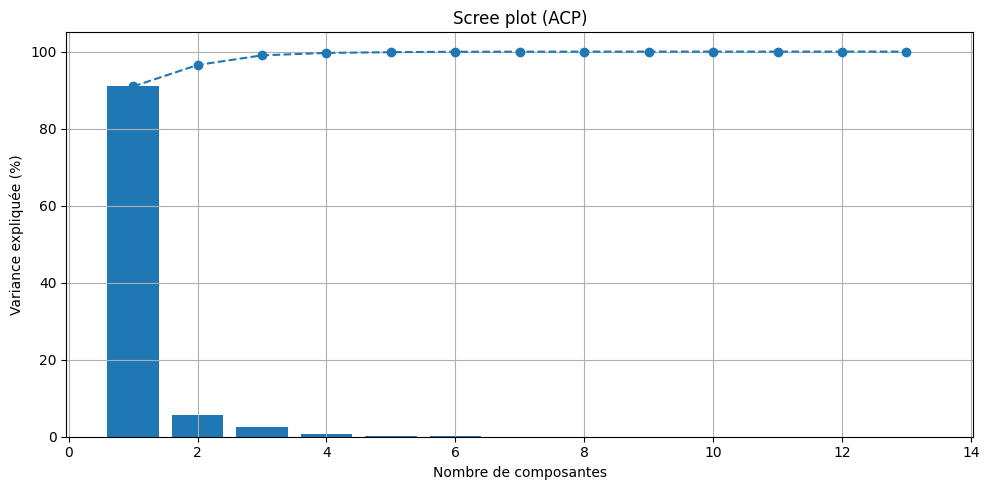

In [68]:
# Standardisation des données
sc = StandardScaler()
X_std = sc.fit_transform(df_pivot_pca)
X_std = pd.DataFrame(X_std, columns=df_pivot_pca.columns, index=df_pivot_pca.index)

# ACP
components = X_std.shape[1]
pca = PCA(n_components=components)
pca.fit(X_std)

# Variance expliquée
x = list(range(1, components + 1))
y = pca.explained_variance_ratio_ * 100

# Scree plot
plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.plot(x, np.cumsum(y), marker='o', linestyle='--')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée (%)")
plt.title("Scree plot (ACP)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
# Application de l'ACP à 2 composantes
pca_2 = PCA(n_components=2)
X_2D = pca_2.fit_transform(X_std)

# Création du DataFrame PCA avec index = Region, Year
df_pca = pd.DataFrame(X_2D, columns=['PC1', 'PC2'], index=df_pivot_pca.index).reset_index()

# Calcul des loadings
loadings = pd.DataFrame(
    pca_2.components_.T,
    index=df_pivot_pca.columns,
    columns=['PC1', 'PC2']
)

# Affichage des top variables
top_PC1 = loadings['PC1'].abs().sort_values(ascending=False).head(5)
top_PC2 = loadings['PC2'].abs().sort_values(ascending=False).head(5)
print(top_PC1)
print(top_PC2)

Indicator
Individuals using the Internet(Millions)          0.289577
Active mobile-broadband subscriptions             0.289381
Fixed-broadband subscriptions                     0.287773
Individuals owning a mobile phone***(Millions)    0.287351
Population covered by at least an LTE             0.283881
Name: PC1, dtype: float64
Indicator
Population covered by at least a 5G mobile network    0.546473
International bandwidth usage(Tbits                   0.433389
Fixed broadband traffic(Exabytes)                     0.337629
Population covered by a mobile-cellular network       0.309753
Population covered by at least a 3G mobile network    0.290462
Name: PC2, dtype: float64


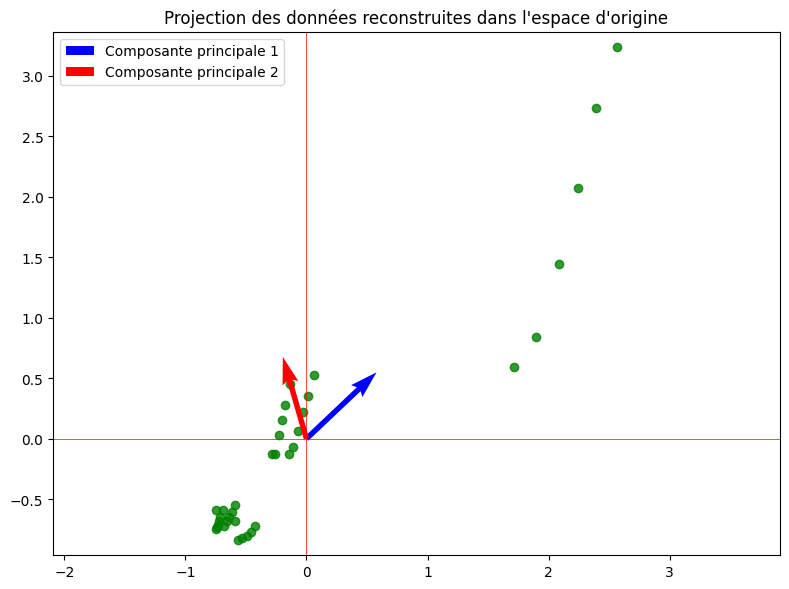

In [74]:
# PCA avec 2 composantes
components = 2
pca = PCA(n_components=components)

# Réduction de dimension
X_pca = pca.fit_transform(X_std)

# Reconstruction (pour le nuage reconstruit)
X_new = pca.inverse_transform(X_pca)

# Affichage du nuage projeté sur les 2 premières composantes
plt.figure(figsize=(8, 6))
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8, color='green')

plt.axis('equal')
plt.quiver(pca.mean_[0], pca.mean_[1], pca.components_[0, 0], pca.components_[0, 1],
           scale=3, color='b', label='Composante principale 1')
plt.quiver(pca.mean_[0], pca.mean_[1], pca.components_[1, 0], pca.components_[1, 1],
           scale=3, color='r', label='Composante principale 2')

plt.axhline(0, color='red', linewidth=0.5)  # Axe horizontal
plt.axvline(0, color='red', linewidth=0.5)  # Axe vertical
plt.legend()
plt.title("Projection des données reconstruites dans l'espace d'origine")
plt.tight_layout()
plt.show()


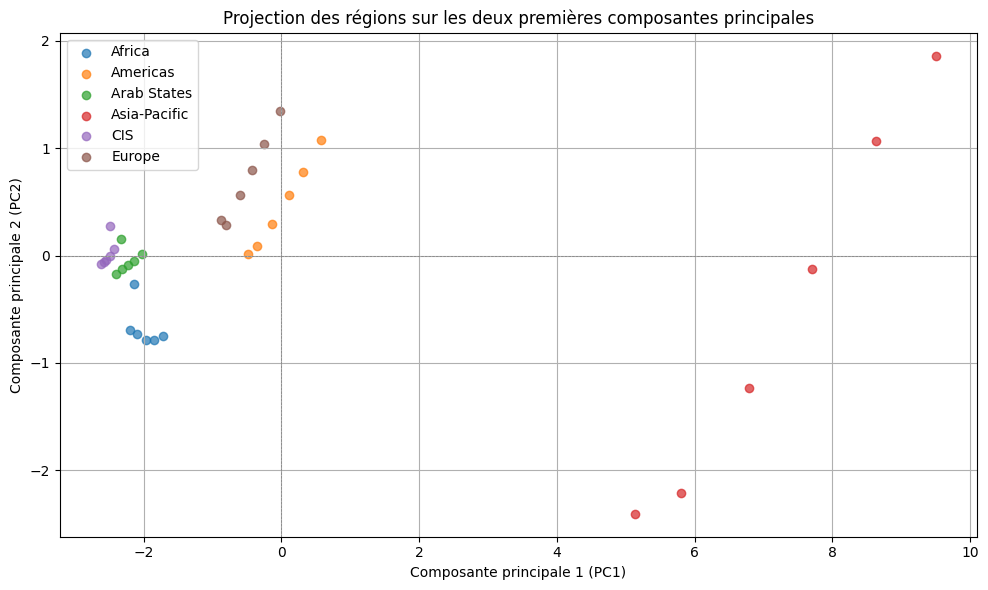

In [71]:
# Scatterplot des observations projetées sur PC1 et PC2
plt.figure(figsize=(10, 6))
for region in df_pca['Region'].unique():
    subset = df_pca[df_pca['Region'] == region]
    plt.scatter(subset['PC1'], subset['PC2'], label=region, alpha=0.7)

plt.xlabel("Composante principale 1 (PC1)")
plt.ylabel("Composante principale 2 (PC2)")
plt.title("Projection des régions sur les deux premières composantes principales")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Partie 4 : Modélisation supervisée
Nous testons plusieurs modèles pour prédire la valeur de 2024 à partir des années précédentes.

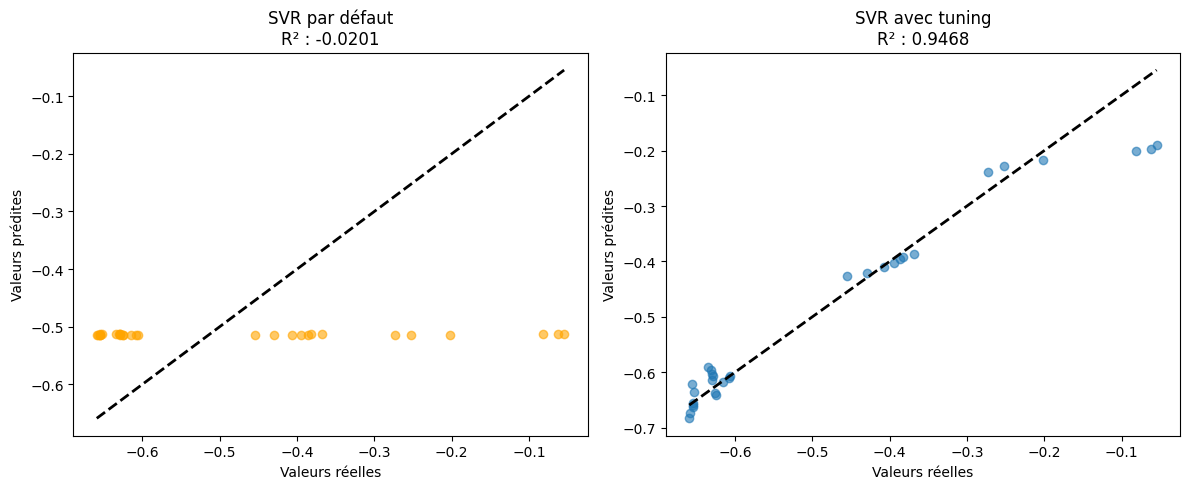

In [77]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('data.csv')

# Création du DataFrame pour SVR
df_svr = df_cleaned_rows[df_cleaned_rows["Indicator"] == "Fixed-telephone subscriptions"][
    ["Year", "Region", "Value_millions"]
].rename(columns={"Value_millions": "Value_millions_Fixed-telephone subscriptions"})

# Encodage des régions
df_svr = pd.get_dummies(df_svr, columns=["Region"])

# Séparation des données
X = df_svr.drop(columns="Value_millions_Fixed-telephone subscriptions")
Y = df_svr["Value_millions_Fixed-telephone subscriptions"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# SVR sans tuning
model_default = SVR()
model_default.fit(X_train, Y_train)
y_pred_default = model_default.predict(X_test)

# SVR avec tuning
model_tuned = SVR(kernel='linear', C=10, degree=2, gamma=0.001, epsilon=0.01)
model_tuned.fit(X_train, Y_train)
y_pred_tuned = model_tuned.predict(X_test)

# Évaluation des deux modèles
r2_default = r2_score(Y_test, y_pred_default)
r2_tuned = r2_score(Y_test, y_pred_tuned)

# Affichage des résultats
plt.figure(figsize=(12, 5))

# Modèle par défaut
plt.subplot(1, 2, 1)
plt.scatter(Y_test, y_pred_default, alpha=0.6, color='orange')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title(f"SVR par défaut\nR² : {r2_default:.4f}")

# Modèle tuné
plt.subplot(1, 2, 2)
plt.scatter(Y_test, y_pred_tuned, alpha=0.6)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title(f"SVR avec tuning\nR² : {r2_tuned:.4f}")

plt.tight_layout()
plt.show()


/Users/abou/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/abou/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/abou/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/abou/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined 

Évaluation du modèle SVC sans tuning :
              precision    recall  f1-score   support

      Africa       0.00      0.00      0.00         0
    Americas       1.00      1.00      1.00         1
 Arab States       1.00      0.50      0.67         2
Asia-Pacific       1.00      1.00      1.00         1
         CIS       1.00      1.00      1.00         2
      Europe       1.00      1.00      1.00         2

    accuracy                           0.88         8
   macro avg       0.83      0.75      0.78         8
weighted avg       1.00      0.88      0.92         8

Accuracy : 0.88

Évaluation du modèle SVC avec tuning :
              precision    recall  f1-score   support

    Americas       1.00      1.00      1.00         1
 Arab States       1.00      1.00      1.00         2
Asia-Pacific       1.00      1.00      1.00         1
         CIS       1.00      1.00      1.00         2
      Europe       1.00      1.00      1.00         2

    accuracy                        

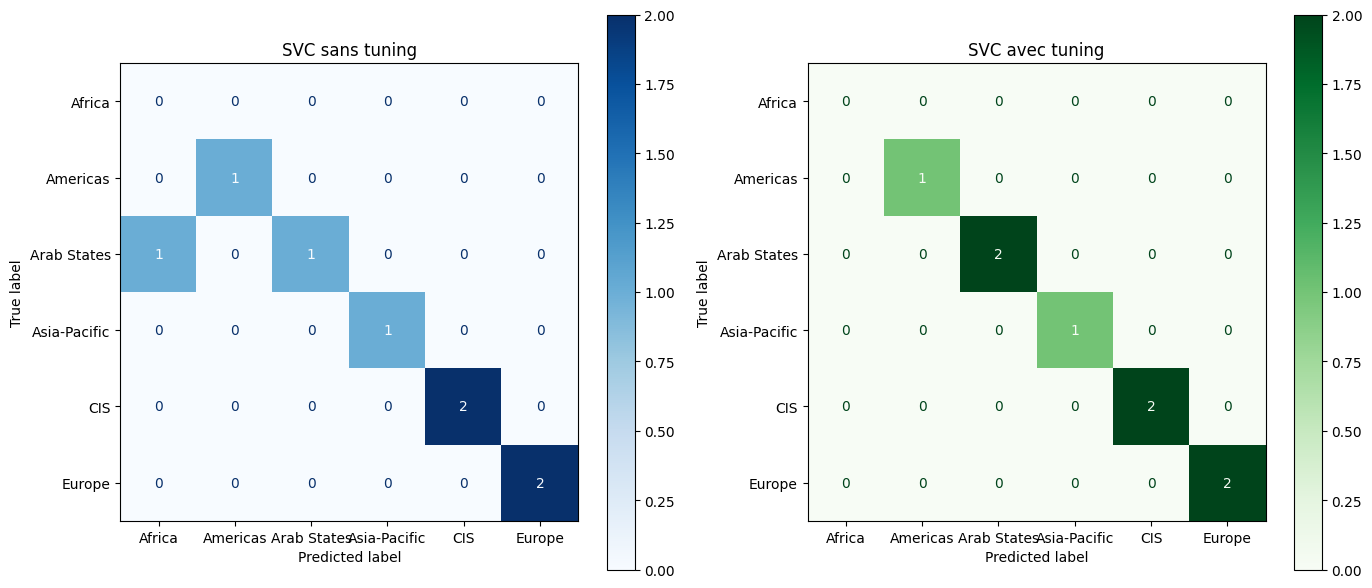

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Création du pivot
df_pivot = df.pivot_table(index=["Region", "Year"], columns="Indicator", values="Value_per100")
df_pivot = df_pivot.dropna(thresh=int(df_pivot.shape[1] * 0.85)).copy()
df_pivot.fillna(df_pivot.mean(), inplace=True)
df_pivot = df_pivot.reset_index()

# Séparation des features et de la cible
X = df_pivot.drop(columns=["Region", "Year"])
y = df_pivot["Region"]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en ensemble train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=18)

# Implémentation SVC sans tuning
svc_default = SVC()
svc_default.fit(X_train, y_train)
y_pred_default = svc_default.predict(X_test)

# GridSearchCV pour tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'degree': [2, 3],
    'gamma': [0.01, 0.1],
    'kernel': ['rbf', 'poly']
}
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Meilleur modèle après tuning
svc_tuned = grid_search.best_estimator_
y_pred_tuned = svc_tuned.predict(X_test)

# Évaluation
print("Évaluation du modèle SVC sans tuning :")
print(classification_report(y_test, y_pred_default))
print(f"Accuracy : {accuracy_score(y_test, y_pred_default):.2f}")

print("\nÉvaluation du modèle SVC avec tuning :")
print(classification_report(y_test, y_pred_tuned))
print(f"Accuracy : {accuracy_score(y_test, y_pred_tuned):.2f}")

# Matrices de confusion
cm_default = confusion_matrix(y_test, y_pred_default, labels=svc_default.classes_)
cm_tuned = confusion_matrix(y_test, y_pred_tuned, labels=svc_tuned.classes_)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=svc_default.classes_).plot(ax=axs[0], cmap='Blues')
axs[0].set_title("SVC sans tuning")
ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=svc_tuned.classes_).plot(ax=axs[1], cmap='Greens')
axs[1].set_title("SVC avec tuning")
plt.tight_layout()
plt.show()